In [12]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm
import matplotlib.pyplot as plt

downgrade_labels = False
force = True

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching, force=True)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")
labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

# Prepare data for generate_dataset.
year = 2020
only_bands = ["r", "b", "g", "n"]
signs_paths = (
    signs.query(f"year == {year} and season == 'mon' and band in @only_bands")
    .sort_values("month")
    .sort_values("band")
)
signs_paths = signs_paths["path"].to_list()
labels_paths = labels.query(f"year == {year}")["path"].to_list()

Parsed 8 tifs of type 'sign' and saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Parsed 4 tifs of type 'label' and saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv


In [13]:
signs_paths

['/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_07_mon_comp.b.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_09_mon_comp.b.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_07_mon_comp.g.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_09_mon_comp.g.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_07_mon_comp.n.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_09_mon_comp.n.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_07_mon_comp.r.tif',
 '/Users/stephenhawking/Coding/ML/low2high_map/src/../data/input/images_10m/Sentinel_Samara/reg_64_2020_09_mon_comp.r.tif']

In [39]:
homogen_layer = load_tif(
    "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/layers/homogeneous_layer.tif",
    only_first=True,
)
label = load_tif(
    "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif",
    only_first=True,
)

homogen_layer = homogen_layer["array"]
label = label["array"]

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/layers/homogeneous_layer.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.


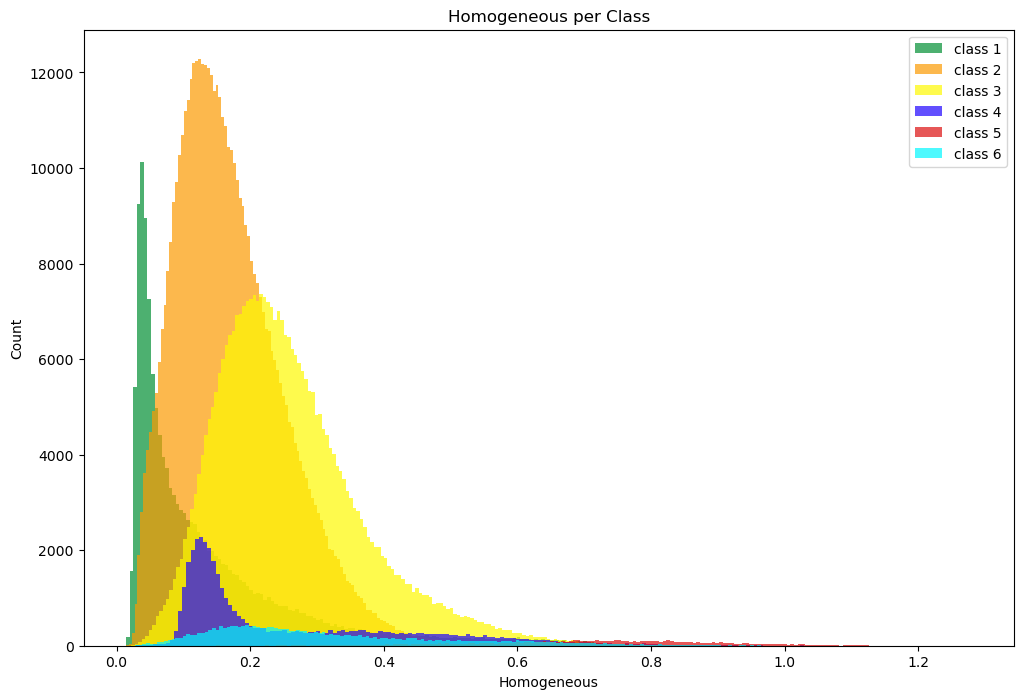

In [21]:
mask = homogen_layer > 0
l = label[mask].ravel()
b = homogen_layer[mask].ravel()

cl = np.unique(l)

plt.figure(figsize=(12, 8))
for c in cl:
    plt.hist(
        b[l == c], alpha=0.7, label=f"class {c}", bins=200, color=color_palette_plot[c]
    )
# plt.xlim(0, 1
plt.xlabel("Homogeneous")
plt.ylabel("Count")
plt.title("Homogeneous per Class")
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

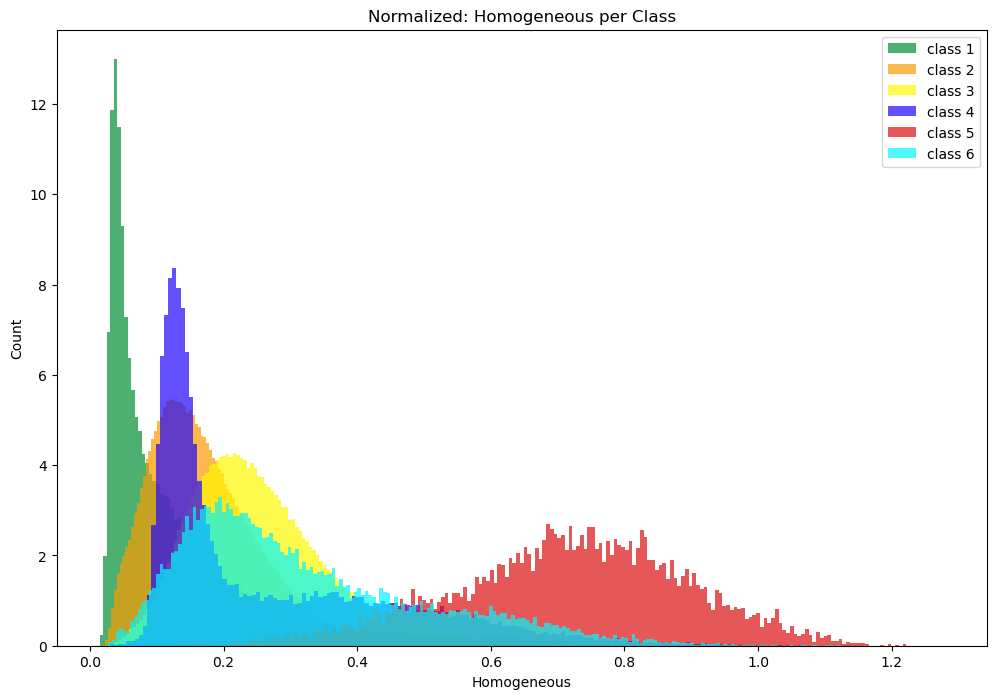

In [22]:
plt.clf()
plt.figure(figsize=(12, 8))
for c in cl:
    plt.hist(
        b[l == c],
        alpha=0.7,
        label=f"class {c}",
        bins=200,
        color=color_palette_plot[c],
        density=True,
    )
# plt.xlim(0, 1
plt.xlabel("Homogeneous")
plt.ylabel("Count")
plt.title("Normalized: Homogeneous per Class")
plt.legend()
plt.show()

/var/folders/hx/5lp4fxm91n123qr24t8v1g3w0000gn/T/ipykernel_38935/4040651371.py:3: RuntimeWarning: invalid value encountered in divide
  means = sum_brightless / counts


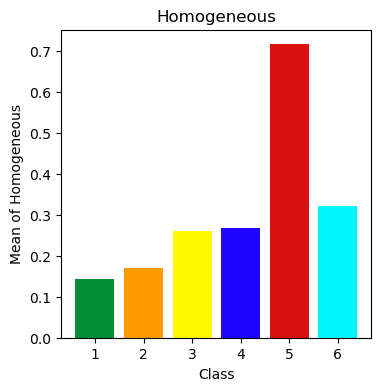

In [36]:
sum_brightless = np.bincount(l, weights=b)
counts = np.bincount(l)
means = sum_brightless / counts

classes = np.arange(len(means))
colors = [color_palette_plot[c] for c in classes]

plt.figure(figsize=(4, 4))
plt.bar(classes, means, color=colors)
plt.xlabel("Class")
plt.ylabel("Mean of Homogeneous")
plt.title("Homogeneous")
plt.show()

In [23]:
# Check of the correlation with: NDVI, SAWI, NDMI

r = "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/images/reg_64_2020_06_90d_comp.r.tif"
r = load_tif(r, only_first=True)["array"].astype(np.float64)

n = "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/images/reg_64_2020_06_90d_comp.n.tif"
n = load_tif(n, only_first=True)["array"].astype(np.float64)

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/images/reg_64_2020_06_90d_comp.r.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/resized/images/reg_64_2020_06_90d_comp.n.tif
Files was loaded.


0.3283485879164349 1914160


<Figure size 640x480 with 0 Axes>

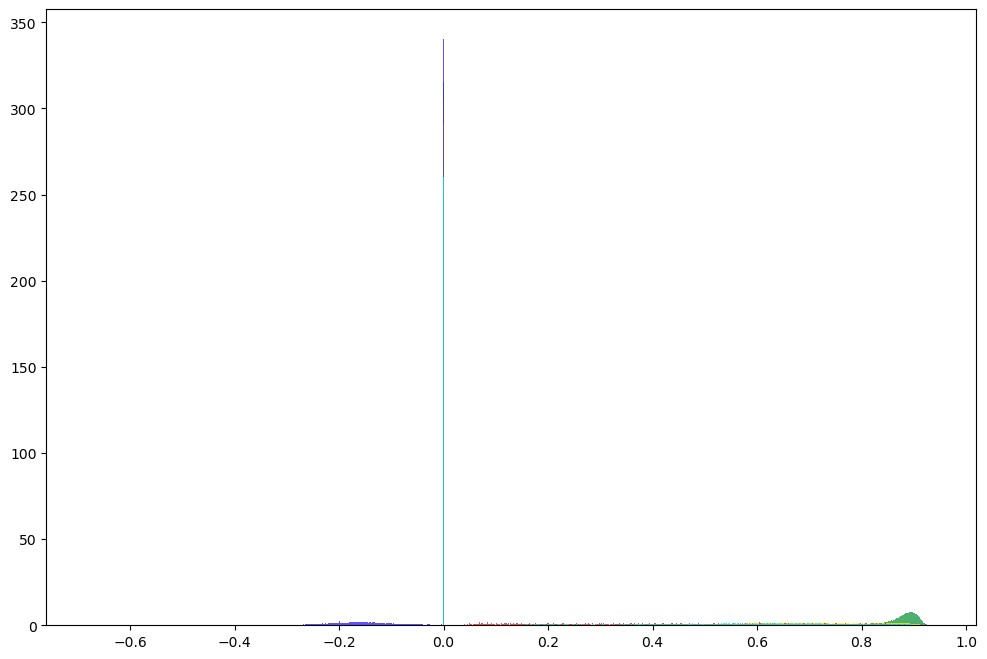

In [24]:
mask = r > 0
NDVI = (n - r) / (n + r + 1e-6)

# means = np.bincount(l, weights=NDVI)

plt.clf()
plt.figure(figsize=(12, 8))
for c in np.unique(label):
    plt.hist(
        NDVI[label == c],
        alpha=0.7,
        label=f"class {c}",
        bins=1000,
        color=color_palette_plot[c],
        density=True,
    )

# plt.xlim(0, 1)
print(NDVI.mean(), NDVI.size)

In [22]:
print("r: ", r.max(), r.min(), r.dtype)
print("n: ", n.max(), n.min(), n.dtype)
print("ndvi: ", NDVI.max(), NDVI.min(), NDVI.dtype)

r:  11648 0 uint16
n:  13432 0 uint16
ndvi:  648.782171794236 0.0 float64


5.424265008391651 1916929


<Figure size 640x480 with 0 Axes>

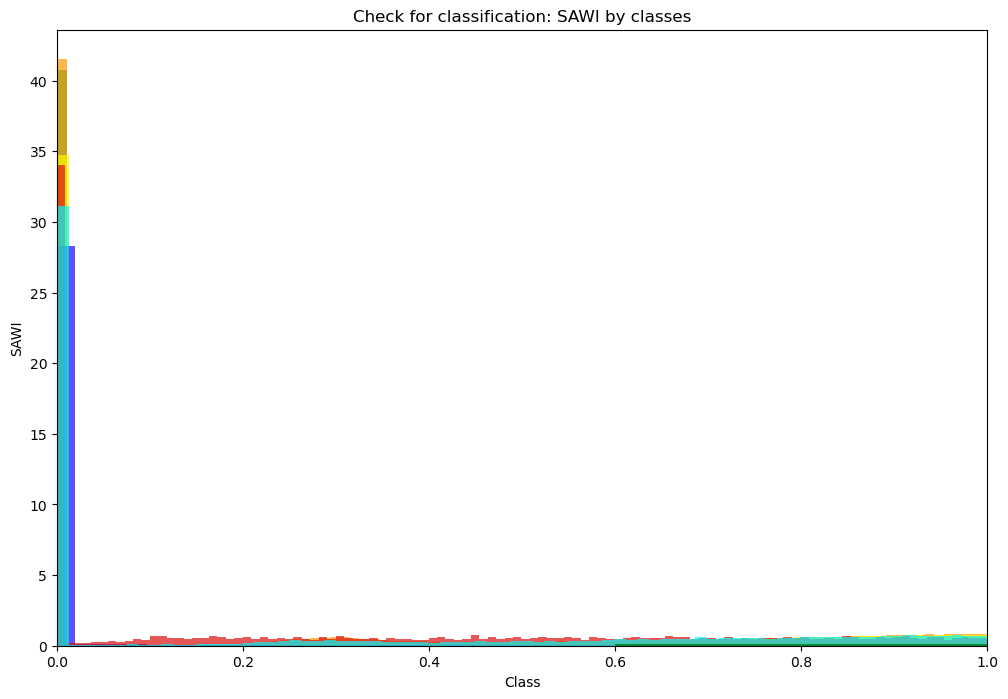

In [42]:
mask = r > 0
L = 0.5
SAWI = (n - r) / (n + r + L + 1e-6) * (1 + L)

# means = np.bincount(l, weights=NDVI)

plt.clf()
plt.figure(figsize=(12, 8))
for c in np.unique(label):
    plt.hist(
        SAWI[label == c],
        alpha=0.7,
        label=f"class {c}",
        bins=50000,
        color=color_palette_plot[c],
        density=True,
    )

plt.xlim(0, 1)
print(SAWI.mean(), SAWI.size)
plt.bar(classes, means, color=colors)
plt.xlabel("Class")
plt.ylabel("SAWI")
plt.title("Check for classification: SAWI by classes")
plt.show()

Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/px_of_std_landcover23c_v571_2020.Samara.tif
Files was loaded.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif
Files was loaded.


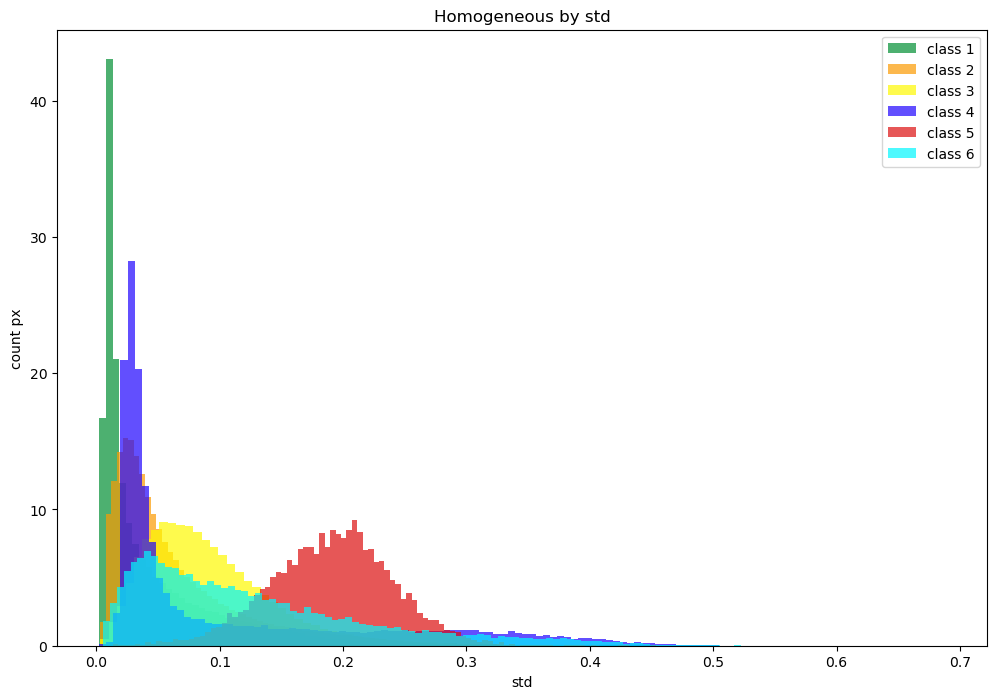

In [ ]:
homogen_layer = load_tif(
    "/Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/resized/layers/px_of_std_landcover23c_v571_2020.Samara.tif",
    only_first=True,
)
label = load_tif(
    "/Users/stephenhawking/Coding/ML/low2high_map/data/processing/cropped/labels/landcover23c_v571_2020.Samara.tif",
    only_first=True,
)

homogen_layer = homogen_layer["array"]
label = label["array"]

mask = homogen_layer > 0
l = label[mask].ravel()
b = homogen_layer[mask].ravel()

cl = np.unique(l)

plt.figure(figsize=(12, 8))
for c in cl:
    plt.hist(
        b[l == c],
        alpha=0.7,
        label=f"class {c}",
        bins=100,
        color=color_palette_plot[c],
        density=True,
    )
plt.xlabel("std")
plt.ylabel("count px")
plt.title("Homogeneous by std")
# plt.xlim(0, 2)
plt.legend()
plt.show()

[0.009939584136009216, 0.02314791940152645, 0.04828087836503983, 0.027438073232769967, 0.14935394525527954, 0.045507299900054934]


<BarContainer object of 6 artists>

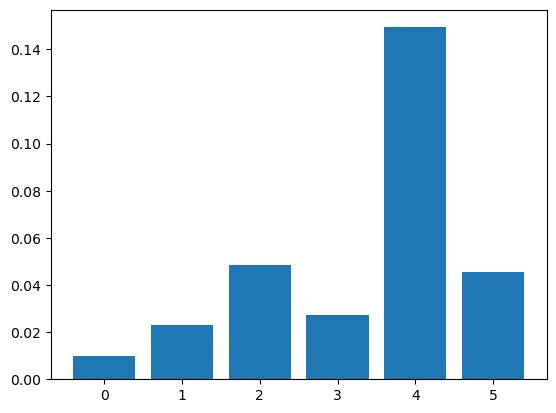

In [37]:
homogen_mask = mask.ravel()
homogen_percent = 0.2

classes = np.unique(l)
quantiles = []
for cl in classes:
    q = np.quantile(b[l == cl], homogen_percent)
    quantiles.append(q)
print(quantiles)
plt.bar(np.arange(len(quantiles)), quantiles)